# Collecte et analyse de tweets

Twitter met à disposition une API pour interagir avec son service. Cette API nécessite des codes d'accès développeurs, accordés par Twitter. Suivant cet accès, les limites sont plus ou moins importantes. Plus d'information sur les conditions ici : https://developer.twitter.com/en

Dans le cas de ce notebook, l'accès académique est utilisé permettant de requêter les archives de Twitter depuis sa création.

Le cas traité ici est assez classique : l'objectif est de suivre sur plusieurs années les échanges autour d'un événement particulier, une campagne de prévention des cancers du sein. Les acteurs publics organisent une campagne autour du thème "Octobre Rose". Une partie de cette campagne a lieu sur les réseaux sociaux. Qui sont les acteurs qui diffusent cette campagne, quelle est la part des relais des utilisateurs, etc.

Le processus de traitement va mettre en lien plusieurs briques différentes :

1. La collecte des données à partir de l'API Twitter
2. Le nettoyage d'un corpus de taille potentiellement conséquente
3. L'analyse exploratoire
4. Le traitement des données textuelles
5. Le traitement des données relationnelles

## Etape 1. Collecte des données

Pour la collecte des données, il existe plusieurs bibliothèques. Dans le cas ici, nous utiliserons searchtweets (dont l'utilisation peut être un peu cryptique, j'ai passé un peu de temps avant de comprendre 1/ la logique de l'API Twitter 2/ comment utiliser la bibliothèque.

Par exemple : https://twittercommunity.com/t/searchtweetsv2-incorrect-endpoints/157359/3


Première étape, charger les bibliothèques

In [2]:
import pandas as pd # pour les tableaux
import matplotlib.pyplot as plt # pour les visualisations
import json # pour gérer le format d'échange des données de twitter

#!pip install searchtweets-v2
from searchtweets import ResultStream, gen_request_parameters, load_credentials
from searchtweets import collect_results

Récupération des tweets dans les archives avec un accès académique avec la bibliothèque searchtweets et l'API V2

Configuration du point d'accès (cf https://developer.twitter.com/en/portal/dashboard avec compte académique)

In [4]:
# utilisation de l'API v2 (configurer le fichier yaml)
search_args = load_credentials("../../Notebooks complets/.twitter_keys.yaml",
                                yaml_key="search_tweets_v2",
                                env_overwrite=False)

Le fichier .yaml définit le token d'accès (spécifique à mon compte) et le point d'entrée des requêtes

````
search_tweets_v2:
  endpoint: https://api.twitter.com/2/tweets/search/all
  bearer_token: [A RENSEIGNER ICI]
````

Construction d'une requête de test : en effet, la première étape est d'être sur que tout fonctionne bien, et ne pas commencer à collecter toutes les données.

In [5]:
query = gen_request_parameters("octobrerose -is:retweet", 
    granularity=False, 
    results_per_call=100,
    start_time="2021-01-01",
    end_time="2021-01-31",
    expansions="author_id,in_reply_to_user_id,referenced_tweets.id,referenced_tweets.id.author_id,entities.mentions.username,attachments.poll_ids,attachments.media_keys,geo.place_id",
    tweet_fields="attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,text,possibly_sensitive,referenced_tweets,reply_settings,source,withheld",
    user_fields="created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld",
    media_fields="duration_ms,height,media_key,preview_image_url,type,url,width,public_metrics",
    poll_fields="duration_minutes,end_datetime,id,options,voting_status",
    place_fields="contained_within,country,country_code,full_name,geo,id,name,place_type"                        
                              )
print(query)

{"query": "octobrerose -is:retweet", "start_time": "2021-01-01T00:00:00Z", "end_time": "2021-01-31T00:00:00Z", "max_results": 100, "tweet.fields": "attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,text,possibly_sensitive,referenced_tweets,reply_settings,source,withheld", "user.fields": "created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld", "media.fields": "duration_ms,height,media_key,preview_image_url,type,url,width,public_metrics", "place.fields": "contained_within,country,country_code,full_name,geo,id,name,place_type", "poll.fields": "duration_minutes,end_datetime,id,options,voting_status", "expansions": "author_id,in_reply_to_user_id,referenced_tweets.id,referenced_tweets.id.author_id,entities.mentions.username,attachments.poll_ids,attachments.media_keys,geo.place_id"}


Exécution de la requête de test

In [6]:
tweets = collect_results(query,
                         max_tweets=1000,
                         result_stream_args=search_args)

Vérification de ce qui est retourné - il faut comprendre la structure des données en regardant ce qui est dedans

In [7]:
len(tweets)

1

In [15]:
tweets[0].keys()

dict_keys(['data', 'includes', 'meta'])

In [17]:
tweets[0]["data"][0]

{'source': 'Twitter for Android',
 'id': '1355460529100361729',
 'created_at': '2021-01-30T10:19:08.000Z',
 'lang': 'fr',
 'text': '❤️😢❤️😢❤️😢❤️😢❤️😢\nClairement \nPendant que....\nIl y a tellement plus important dans la vie \nLa vie est courte \nPensée à mon amie 😢 tu me manques trop 😔\n#FoutuCancer\n#OctobreRose\n#Oser https://t.co/DA7sexJwYc',
 'possibly_sensitive': False,
 'entities': {'urls': [{'start': 181,
    'end': 204,
    'url': 'https://t.co/DA7sexJwYc',
    'expanded_url': 'https://twitter.com/DANIEL_072021/status/1355446417813336065',
    'display_url': 'twitter.com/DANIEL_072021/…'}],
  'hashtags': [{'start': 149, 'end': 161, 'tag': 'FoutuCancer'},
   {'start': 162, 'end': 174, 'tag': 'OctobreRose'},
   {'start': 175, 'end': 180, 'tag': 'Oser'}]},
 'author_id': '1185648828516569088',
 'conversation_id': '1355460529100361729',
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'reply_settings': 'everyone'}

En regardant en détail, on se rend compte que les données des tweets sont dans data, et que les informations sur les utilisateurs sont dans includes, avec le numéro d'user comme lien entre les deux

### Passer à la collecte "industrielle"

Script pour la collecte année par année depuis 2011 jusqu'à 2020 des tweets mentionnant octobrerose (indépendamment des majuscules), en ne collectant pas les retweets, puis sauvegarde dans un fichier json par année. Le choix est fait de découper par années pour pouvoir ensuite plus facilement manipuler les données

In [ ]:
table_tweets = []
table_users = []

for i in range(2011,2021):
    print(i)
    
    # Construction de la requête sur une année
    query = gen_request_parameters("octobrerose -is:retweet", 
        granularity=False, 
        results_per_call=100,
        start_time="%d-01-01"%i,
        end_time="%d-12-31"%i,
        expansions="author_id,in_reply_to_user_id,referenced_tweets.id,referenced_tweets.id.author_id,entities.mentions.username,attachments.poll_ids,attachments.media_keys,geo.place_id",
        tweet_fields="attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,text,possibly_sensitive,referenced_tweets,reply_settings,source,withheld",
        user_fields="created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld",
        media_fields="duration_ms,height,media_key,preview_image_url,type,url,width,public_metrics",
        poll_fields="duration_minutes,end_datetime,id,options,voting_status",
        place_fields="contained_within,country,country_code,full_name,geo,id,name,place_type"  )      
    
    # Collecte
    tweets = collect_results(query,
                         max_tweets=100000,
                         result_stream_args=search_args)
    print("Nombre ",len(tweets)*100)
    
    # Sauvegarde dans un fichier
    json.dump(tweets,open("tweets-OR/%d.json"%i,"w"))
    


## Etape 2. Chargement des données et exploration

La phase de collecte est achevée. Les données sont stockées. Il est maintenant possible de les analyser. Pour cela, on va faire une lecture des fichiers sauvegardées et construction d'un tableau Pandas.

Pour cela, il faut se plonger dans la structure des données. **Attention**, il y a surement plus esthétique que ce qui est fait ici ;)

L'objectif final est de produire un tableau qui permette l'analyse des données.

Ce script vise à reprendre les fichiers stockés sur le disque dur et à les mettre dans un tableau

In [3]:
table_tweets = []
table_users = []
table_total = []

for i in range(2011,2022):
    
    #ouverture du fichier
    tweets = json.load(open("tweets-OR/%d.json"%i,"r"))
    table_tweets_annee = []
    table_users_annee = []
    
    #parcours des éléments
    for p in tweets:
        for t in p["data"]:
            table_tweets_annee.append([t["id"], t['created_at'], t["author_id"],t["text"],t['public_metrics']['retweet_count'],t['public_metrics']['like_count']])
        for u in p["includes"]["users"]:
            table_users_annee.append([u["id"],u["name"],u["username"],u['created_at'],u["description"],u['public_metrics'],i])
    table_tweets += table_tweets_annee 
    table_users += table_users
    
    table_tweets_annee = pd.DataFrame(table_tweets_annee,columns=["id","date","auteur","texte","nb_retweets","nb_likes"])
    table_users_annee = pd.DataFrame(table_users_annee,columns = ["id","name","username","date","description","metrics","annee"])
    
    # rajouter les informations sur les utilisateurs
    def reco(x):
        try:
            return dict(table_users_annee.loc[x].iloc[0])
        except:
            return dict(table_users_annee.loc[x])
    table_users_annee = table_users_annee.set_index("id")
    table_tweets_annee["info_user"] = table_tweets_annee["auteur"].apply(reco)
    table_total.append(table_tweets_annee)
    
# Création tableaux dataframes des tweets d'un côté, et des utilisateurs de l'autre
table_tweets = pd.DataFrame(table_tweets,columns=["id","date","auteur","texte","nb_retweets","nb_likes"])
table_users = pd.DataFrame(table_users,columns = ["id","name","username","date","description","metrics","annee"])
table_total = pd.concat(table_total)



# Ajouts d'éléments au tableau
def get_info(x,y,z=False):
    try:
        if not z:
            return x[y]
        else:
            return x[y][z]
    except:
        return None
table_total["name_user"] = table_total["info_user"].apply(lambda x : get_info(x,"name"))
table_total["name_description"] = table_total["info_user"].apply(lambda x : get_info(x,"description"))
table_total["following_user"] = table_total["info_user"].apply(lambda x : get_info(x,"metrics","following_count"))
table_total["followers_user"] = table_total["info_user"].apply(lambda x : get_info(x,"metrics","followers_count"))
table_total["username"] = table_total["info_user"].apply(lambda x : get_info(x,"username"))

# Mise en forme
table_tweets["date"] = pd.to_datetime(table_tweets["date"])
table_total["date"] = pd.to_datetime(table_total["date"])
table_tweets = table_tweets.set_index("date")
table_total = table_total.set_index("date")
table_users = table_users.set_index("id")

#### A améliorer : lien entre les tweets et les comptes

la table des utilisateurs comprend toutes les variations des comptes utilisateurs, qui peut donc apparaitre plusieurs fois. Pour pouvoir ajouer les informations sur le tableau des tweets, il faut donc choisir un seul élément. Par ailleurs comme on est sur un temps long, cela peut varier, il faut veiller à prendre un élément de l'année

## Analyse

### Quelques statistiques descriptives

Les 10 tweets les plus retweetés

In [4]:
table_total.sort_values("nb_retweets",ascending=False)[0:10]

,id,auteur,texte,nb_retweets,nb_likes,info_user,name_user,name_description,following_user,followers_user,username
date,,,,,,,,,,,
2020-10-01 09:17:40+00:00,1311596130816462848,1155461718274957312,Mon plus grand soutient à toutes ces Femmes qu...,21462,17358,"{'name': 'A nurse 💉', 'username': 'silya_liya'...",A nurse 💉,,286.0,3752.0,silya_liya
2020-10-04 11:31:57+00:00,1312717089283674112,2361533452,Je trouve qu’on parle pas assez d’#OctobreRose...,19065,14975,"{'name': 'maty 👻', 'username': 'irwinnielourso...",maty 👻,a.r | lily&laura | alexie ♡ | d•b•m | she/her ...,872.0,1692.0,irwinnielourson
2020-10-01 07:46:58+00:00,1311573304482893825,1248627626098348033,Nous sommes le 1er octobre. Un mois de sensibi...,5144,4803,"{'name': 'S', 'username': 'sirinexium_', 'date...",S,25 ans - Infirmière intérimaire et féministe. ...,396.0,3832.0,sirinexium_
2020-10-06 22:22:38+00:00,1313605612593442822,335134859,Ce tweet est très important. Les femmes noires...,4633,1915,"{'name': 'Live Love Laugh 🧡🇸🇳', 'username': 'A...",Live Love Laugh 🧡🇸🇳,Docteur en médecine. Pediatric resident 🥼\n#Af...,1811.0,4563.0,Atschou
2020-10-13 17:38:25+00:00,1316070804443082753,1214315619031478272,🏊 Quel beau geste ! Il s'appelle Christophe Ma...,3383,11465,"{'name': 'Mediavenir', 'username': 'Mediavenir...",Mediavenir,🌐 L’actualité en temps réel | 🗞 Sources sur @M...,4.0,1441087.0,Mediavenir
2015-10-01 09:51:52+00:00,649522105231540224,16924183,1 RT = 1 Rose envoyée dans un centre d'accueil...,3270,276,"{'name': 'Interflora ❤️', 'username': 'Interfl...",Interflora ❤️,"Coucou, moi c'est Flora, je suis une fleur, je...",6317.0,73933.0,Interflora
2021-10-01 17:14:19+00:00,1443987653985243138,3049390761,Je fais également tourner ! 1er octobre rappel...,2989,2063,"{'name': 'le garcon au bob', 'username': 'bebe...",le garcon au bob,rien à dire,5094.0,6584.0,bebeportugais
2018-10-19 15:06:29+00:00,1053301366297411584,950341134,À toutes celles qui se battent contre le cance...,2773,21356,"{'name': 'Antoine Griezmann', 'username': 'Ant...",Antoine Griezmann,Champion du monde ⭐️⭐️ et parrain de l’associa...,49.0,8273673.0,AntoGriezmann
2016-10-14 12:09:55+00:00,786901850733838337,16924183,20 RT = 1 Bouquet envoyé dans un centre d'accu...,2698,474,"{'name': 'Interflora ❤️', 'username': 'Interfl...",Interflora ❤️,"Coucou, moi c'est Flora, je suis une fleur, je...",6317.0,73933.0,Interflora


Nombre total de retweets

In [6]:
table_total["nb_retweets"].sum()

272063

Nombre total de comptes engagés

In [193]:
table_total["name_user"].value_counts()

Institut Curie            618
Ruban Rose                502
Le Blog de Gaston ⭐⭐      319
Accuray France            297
RadiotherapieFr           290
                         ... 
/\rrak¡ss 🇫🇷                1
Primesautier                1
Media Conseil Presse        1
Stéphanie Bazylak           1
DC Préparation Mentale      1
Name: name_user, Length: 29110, dtype: int64

Environ 30000 comptes différents... avec en tête l'institut Curie, avec 618 tweets

### Graphique d'évolution

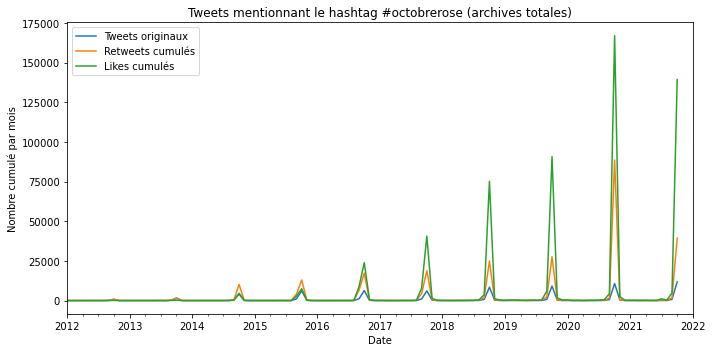

In [174]:
ax = table_total["nb_retweets"].resample("m").count().plot(figsize=(10,5))
ax = table_total["nb_retweets"].resample("m").sum().plot(ax=ax)
ax = table_total["nb_likes"].resample("m").sum().plot(ax=ax)


plt.xlim("2012-01-01","2022-01-01")
plt.legend(["Tweets originaux","Retweets cumulés","Likes cumulés"])
plt.xlabel("Date")
plt.ylabel("Nombre cumulé par mois")
plt.title("Tweets mentionnant le hashtag #octobrerose (archives totales)")
plt.tight_layout()
plt.savefig("evolutionOR.png")

## Traitement sur les hashtags

In [4]:
# Récupérer les hashtags d'une chaîne de caractères
def get_hash(x):
    if pd.isnull(x):
        return None
    t = x.replace("."," ").replace(","," ").replace("#"," #").split()
    return [i for i in t if i[0]=="#"]

In [5]:
table_total["hashtags"] = table_total["texte"].str.lower().apply(get_hash)

In [6]:
hashtags = pd.Series([j for i in list(table_total["hashtags"]) for j in i]).value_counts()
hashtags[0:30]

#octobrerose                   72902
#cancerdusein                  13061
#cancer                         6645
#dépistage                      1663
#sein                           1492
#rubanrose                      1458
#pinkoctober                    1444
#depistage                      1255
#santé                          1166
#octobrerose2021                 960
#breastcancer                    858
#octobrerose2020                 855
#prévention                      802
#prevention                      794
#octobrerose]                    785
#solidarité                      731
#hcsmeufr                        704
#generose                        690
#rose                            682
#femmes                          674
#sante                           606
#axaatoutcoeur                   602
#octobrerose🎀                    594
#octobrerose2019                 561
#tousconcernés                   547
#angers                          545
#paris                           545
#

Il faudrait éventuellement faire un recodage...

Nombre de hashtags par tweet

<AxesSubplot:>

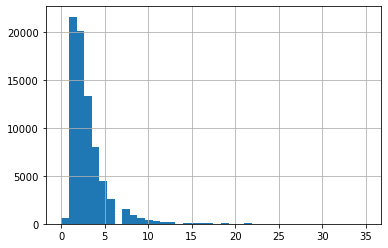

In [199]:
table_total["hashtags"].apply(len).hist(bins=40)

Si on veut faire un petit réseau à visualiser sous Gephi ?

On utilise la bibliothèque networkx, et itertools pour les combinaisons

In [209]:
import networkx as nx
import itertools

G = nx.Graph()
for k,l in table_total.iterrows():
    for h in l["hashtags"]:
        if h in G.nodes:
            G.nodes[h]["weight"]+=1
        else:
            G.add_node(h,weight=1)
        
    for i,j in itertools.combinations(l["hashtags"], 2):
        if G.has_edge(i,j):
            G[i][j]["weight"]+=1
        else:
            G.add_edge(i,j,weight=1)

In [213]:
#G.nodes(data=True)
len(G.edges)

170579

Exporter en format lisible par Gephi

In [214]:
nx.write_graphml(G,"reseau.graphml")

## Récupérer les liens des tweets

à faire ...

## Analyse du contenu textuel

Il existe beaucoup de bibliothèques, comme Nltk, Gensim ou SpaCy. Plusieurs manières de pratique...

In [5]:
import nltk
from nltk.corpus import stopwords
import re

#from nltk.tokenize import word_tokenize
#nltk.download('punkt')
#print(word_tokenize("Ceci est un.",language="french"))

stop_words = stopwords.words('french')
stop_words += ["octobrerose","https","http","co"]

### Tout l'enjeu est de nettoyer ...

Et il y a de nombreuses stratégies.

Au moins trois bibliothèques :

- NLTK : bas niveau, travail sur le contenu
- Gensim : des modèles
- Spacy : ML

https://www.kaggle.com/faressayah/nlp-with-spacy-nltk-gensim

#### Utilisation de spacy

Il y a des bibliothèques basée sur des modèles pré-entrainés puissants... mais la question est toujours si ils donnent des résultats pertinets pour vous

https://spacy.io/usage/spacy-101

On va travailler sur un échantillon pour ne pas prendre trop de temps

In [7]:
table_sample = table_total.sample(1000)

Chaque texte est passé dans 

In [26]:
import spacy
# https://spacy.io/models/fr -> installer le modèle
# !python -m spacy download fr_core_news_md

nlp = spacy.load("fr_core_news_sm")

table_sample["texte-spacy"] = table_sample["texte"].apply(nlp)

In [9]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x14420ae90>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1442578a0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1442577c0>)]

Un élément

In [36]:
### doc = nlp(table_total["texte"].iloc[0])
print(doc)
for token in table_sample["texte-spacy"].iloc[1]:
    print(token.text, token.pos_, token.dep_, token.lemma_, token.tag_)

L'activité sportive diminue le taux de rechute de 50 % et permet de mieux vivre la maladie #cancerdusein #octobrerose http://t.co/MOmkdPM2
🎀 PROPN ROOT 🎀 PROPN___
Début PROPN dep Début PROPN___
de ADP case de ADP___
la DET det le DET__Definite=Def|Gender=Fem|Number=Sing|PronType=Art
27e ADJ amod 27 ADJ__NumType=Ord
édition NOUN nmod édition NOUN__Gender=Fem|Number=Sing
du DET det de DET__Gender=Masc|Number=Sing
mois NOUN nmod mois NOUN__Gender=Masc|Number=Sing
d'#OctobreRose ADP amod d'#octobrerose ADP___
, PUNCT punct , PUNCT___
l' DET det le DET__Definite=Def|Number=Sing|PronType=Art
heure NOUN nsubj heure NOUN__Gender=Fem|Number=Sing
de ADP mark de ADP___
vous PRON iobj vous PRON__Number=Plur|Person=2
rappeler VERB ROOT rappeler VERB__VerbForm=Inf
à ADP case à ADP___
toutes ADJ obl tout ADJ__Gender=Fem|Number=Plur
( PUNCT punct ( PUNCT___
et CCONJ cc et CCONJ___
à ADP case à ADP___
tous PRON conj tout PRON__Gender=Masc|Number=Plur|PronType=Rel
) PUNCT punct ) PUNCT___
qu' PRON mark 

In [38]:
spacy.explain("ADJ")

'adjective'

Ne garder que les noms

In [42]:
def filter_words(x):
    r = []
    for token in x:
        if token.pos_ == "NOUN":
            r.append(token.lemma_)
    return r

In [43]:
table_sample["texte-spacy"].apply(filter_words)

date
2017-09-20 10:06:36+00:00      [octobrerose, 01/10/17, équipe, cause, ♀, ♀, ▶]
2020-10-01 17:53:20+00:00                      [édition, mois, heure, manière]
2017-10-03 16:03:21+00:00                                    [initiative, vik]
2011-10-05 07:29:19+00:00    [hrc, #, octobrerose, pinktober, against, canc...
2021-09-17 11:58:19+00:00    [octobre, cancer, sein, faite, comité, seine, ...
                                                   ...                        
2021-10-09 15:25:31+00:00    [jardin, 🇩, couleur, octobre, 🍁, 💜, 📷, perso, ...
2013-11-01 04:12:34+00:00                                                   []
2014-10-02 12:28:39+00:00             [#, octobrerose, http://t.co/dbjti8jzca]
2020-10-01 07:39:46+00:00    [jour, octobre, participon, sensibilisation, c...
2016-10-09 10:26:32+00:00                             [foulée, ✔, octobrerose]
Name: texte-spacy, Length: 1000, dtype: object

### Contrôler le nettoyage

In [44]:
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import simple_preprocess, lemmatize

table_total["texte_token"] = table_total["texte"].apply(strip_punctuation).apply(simple_preprocess)
table_total["texte_token_filtre"] = table_total["texte_token"].apply(lambda x : [i for i in x if not i in stop_words])

Tokenisation sur l'ensemble des données et création d'un dictionnaire

In [45]:
from gensim import corpora
my_dictionary = corpora.Dictionary(table_total["texte_token_filtre"])

# sauvegarder le dictionnaire
# my_dictionary.save('my_dictionary.dict')
# my_dictionary.save_as_text("test.txt")

# charger le dictionnaire
# load_dict = corpora.Dictionary.load(my_dictionary.dict')b

dic = pd.DataFrame([[my_dictionary[i],my_dictionary.cfs[i]] for i in my_dictionary])
dic.sort_values(1)

,0,1
75561,covoiturauvergn,1
98674,adivalor,1
98673,yyfqnawgtz,1
98672,wkqsm,1
98671,vkfsmn,1
...,...,...
15,contre,11876
42,rose,12440
1,cancerdusein,13435
21,sein,19120


Compresser avec un codage ...

In [49]:
table_total["texte-bow"] = table_total["texte_token_filtre"].apply(lambda x: my_dictionary.doc2bow(x, allow_update = True))
table_total["texte-bow"]

date
2011-11-25 09:15:18+00:00    [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
2011-11-23 09:53:02+00:00    [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1), ...
2011-11-21 19:13:29+00:00    [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1), ...
2011-11-21 19:12:13+00:00    [(22, 1), (23, 1), (24, 1), (26, 1), (27, 1), ...
2011-11-09 20:53:20+00:00    [(22, 1), (36, 1), (37, 1), (38, 1), (39, 1), ...
                                                   ...                        
2021-01-05 15:29:22+00:00    [(55, 1), (253, 1), (1196, 1), (1450, 1), (170...
2021-01-04 18:30:11+00:00    [(3131, 1), (3929, 1), (7345, 1), (15679, 1), ...
2021-01-03 15:42:38+00:00    [(14, 1), (21, 1), (28, 1), (29, 1), (42, 1), ...
2021-01-03 09:56:25+00:00    [(275, 1), (1802, 1), (151118, 1), (151119, 1)...
2021-01-01 10:40:31+00:00    [(1, 1), (24, 1), (51, 1), (71, 1), (81, 1), (...
Name: texte-bow, Length: 75687, dtype: object

Un exemple de traitement TF - IDF

In [50]:
from gensim import models
import numpy as np
BoW_corpus = list(table_total["texte-bow"])
tfIdf = models.TfidfModel(BoW_corpus, smartirs ='ntc')

weight_tfidf =[]
for doc in tfIdf[BoW_corpus]:
    for i, freq in doc:
        weight_tfidf.append([my_dictionary[i], np.around(freq, decimals = 3)])
#print(weight_tfidf) 

In [54]:
weight_tfidf[0:20]

[['activité', 0.261],
 ['cancerdusein', 0.079],
 ['diminue', 0.353],
 ['maladie', 0.179],
 ['mieux', 0.223],
 ['momkdpm', 0.511],
 ['permet', 0.226],
 ['rechute', 0.406],
 ['sportive', 0.295],
 ['taux', 0.297],
 ['vivre', 0.259],
 ['afterwork', 0.327],
 ['bilan', 0.289],
 ['cafe', 0.342],
 ['cancer', 0.046],
 ['contre', 0.076],
 ['hard', 0.357],
 ['hoeyeko', 0.454],
 ['marquante', 0.426],
 ['paris', 0.16]]

Bigrammes

In [56]:
from gensim.models.phrases import Phrases
bigram_model = Phrases(table_total["texte_token_filtre"], min_count = 2, threshold = 10)

trigram_model = Phrases(bigram_model[table_total["texte_token_filtre"]], threshold = 10)

In [58]:
bigram_model[table_total["texte_token_filtre"].iloc[300]]

['catirosi',
 'femmes_font',
 'différence',
 'quotidien',
 'cancersein',
 'souti',
 'asymetriques']

In [59]:
trigram_model[bigram_model[table_total["texte_token_filtre"].iloc[300]]]

['catirosi',
 'femmes_font',
 'différence',
 'quotidien',
 'cancersein',
 'souti',
 'asymetriques']

Récupérer tous les trigrammes produits ...

In [68]:
def tri(x):
    t = trigram_model[bigram_model[x]]
    return [i for i in t if i.count("_")==2]

t = table_total["texte_token_filtre"].apply(tri)

In [74]:
pd.Series([j for i in list(t) for j in i]).value_counts()[0:20]

contre_cancer_sein                1627
dépistage_cancer_sein             1456
lutte_contre_cancer                454
ligue_contre_cancer                383
cancer_sein_parlons                305
comme_chaque_année                 209
mois_octobre_rose                  161
mois_sensibilisation_dépistage     161
cadre_octobre_rose                 152
cette_année_encore                 150
occasion_octobre_rose              145
rubanrose_ans_comme                133
lutter_contre_cancer               130
tout_mois_octobre                  129
soutien_lutte_contre               117
mois_lutte_contre                  110
campagne_octobre_rose              102
cancer_plus_fréquent                99
cet_après_midi                      93
dépistage_sauve_vies                91
dtype: int64

### Aller vers un LDA

Beaucoup de choses jouent dans la modélisation

- qualité du traitement
- identification du nombre de topic
- paramètres de l'algo

In [79]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

dictionnaire = Dictionary(table_total["texte_token_filtre"])
corpus_conv = table_total["texte_token_filtre"].apply(dictionnaire.doc2bow)

lda = LdaModel(corpus=list(corpus_conv),id2word=dictionnaire,num_topics=5)


In [80]:
lda.print_topics()

[(0,
  '0.018*"plus" + 0.017*"femmes" + 0.013*"ans" + 0.013*"dépister" + 0.013*"cancer" + 0.013*"faire" + 0.010*"dépistage" + 0.010*"faites" + 0.010*"cancerdusein" + 0.009*"sein"'),
 (1,
  '0.013*"cause" + 0.009*"pinkoctober" + 0.008*"bonne" + 0.008*"vie" + 0.007*"sauver" + 0.007*"cancerdusein" + 0.007*"soin" + 0.007*"cette" + 0.006*"temps" + 0.006*"october"'),
 (2,
  '0.043*"octobre" + 0.036*"rose" + 0.023*"contre" + 0.023*"cancer" + 0.015*"sein" + 0.015*"mois" + 0.013*"tous" + 0.012*"cancerdusein" + 0.011*"lutte" + 0.009*"cette"'),
 (3,
  '0.011*"don" + 0.009*"mobilisés" + 0.006*"équipes" + 0.006*"hôpital" + 0.005*"sous" + 0.005*"palpation" + 0.005*"propose" + 0.004*"and" + 0.004*"for" + 0.004*"après"'),
 (4,
  '0.080*"cancer" + 0.064*"sein" + 0.034*"dépistage" + 0.025*"cancerdusein" + 0.022*"contre" + 0.012*"sensibilisation" + 0.011*"mois" + 0.011*"prévention" + 0.010*"lutte" + 0.010*"sensibiliser"')]

In [84]:
table_total.iloc[10]["texte"]

'Comme un bijou dans un écrin de lumière rose/Photo du #RubanRose réalisé ENSEMBLE le 29 oct @LeGrandPalais #octobrerose http://t.co/XLnuuJkp'

In [81]:
lda[corpus_conv.iloc[10]]

[(0, 0.019590257),
 (1, 0.019621829),
 (2, 0.9215849),
 (3, 0.019587409),
 (4, 0.019615626)]

https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/